# Orchestrating Machine Learning With Pipelines 

### Introduction to pipelines

**definition** = a workflow of ML tasks in wich each task is implemented as a step (can be arranged sequentially or in parallel)

##### Pipelines steps

#common kind of steps 


- **PythonScriptStep**: Runs a specified Python script.
- **EstimatorStep**: Runs an estimator.
- **DataTransferStep**: Uses Azure Data Factory to copy data between data stores.
- **DatabricksStep**: Runs a notebook, script, or compiled JAR on a databricks cluster.
- **AdlaStep**: Runs a U-SQL job in Azure Data Lake Analytics.




To create a pipeline, you must first define each step and then create a pipeline that includes the steps

In [ ]:
#example of the creation of two steps : the script and the estimator's steps 

from azureml.pipeline.steps import PythonScriptStep, EstimatorStep

# Step to run a Python script
step1 = PythonScriptStep(name = 'prepare data',
                         source_directory = 'scripts',
                         script_name = 'data_prep.py',
                         compute_target = 'aml-cluster',
                         runconfig = run_config)

# Step to run an estimator
step2 = EstimatorStep(name = 'train model',
                      estimator = sk_estimator,
                      compute_target = 'aml-cluster')

Then thoses steps are assigned to the whole pipelines and runned altogether (squentially or in parallel)

In [ ]:
from azureml.pipeline.core import Pipeline
from azureml.core import Experiment

# Construct the pipeline
train_pipeline = Pipeline(workspace = ws, steps = [step1,step2])

# Create an experiment and run the pipeline
experiment = Experiment(workspace = ws, name = 'training-pipeline')
pipeline_run = experiment.submit(train_pipeline)

### Pass Data Between Pipeline steps

##### PipelineData Object

**The PipelineData object is a special kind of DataReference that:**

- **References a location in a datastore.**
- **Creates a data dependency between pipeline steps.**

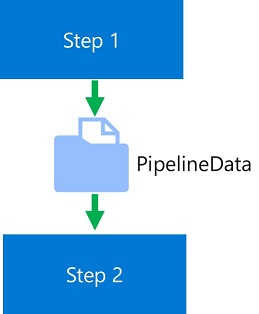

##### PipelineData step inputs and outputs


To use a PipelineData object to pass data between steps, you must:

- Define a named PipelineData object that references a location in a datastore.
- Specify the PipelineData object as an input or output for the steps that use it.
- Pass the PipelineData object as a script parameter in steps that run scripts (and include code in those scripts to read or write data)

Exemples:

In [ ]:
from azureml.pipeline.core import PipelineData
from azureml.pipeline.steps import PythonScriptStep, EstimatorStep

# Get a dataset for the initial data
raw_ds = Dataset.get_by_name(ws, 'raw_dataset')




# 1- Define a named PipelineData object that references a location in a datastore.



# Define a PipelineData object to pass data between steps
data_store = ws.get_default_datastore()
prepped_data = PipelineData('prepped',  datastore=data_store)




# 2- - Specify the PipelineData object as an input or output for the steps that use it.






# Step to run a Python script
step1 = PythonScriptStep(name = 'prepare data',
                         source_directory = 'scripts',
                         script_name = 'data_prep.py',
                         compute_target = 'aml-cluster',
                         runconfig = run_config,
                         # Specify dataset as initial input
                         inputs=[raw_ds.as_named_input('raw_data')],
                         # Specify PipelineData as output
                         outputs=[prepped_data],
                         # Also pass as data reference to script
                         arguments = ['--folder', prepped_data])

# Step to run an estimator
step2 = EstimatorStep(name = 'train model',
                      estimator = sk_estimator,
                      compute_target = 'aml-cluster',
                      # Specify PipelineData as input
                      inputs=[prepped_data],
                      # Pass as data reference to estimator script
                      estimator_entry_script_arguments=['--folder', prepped_data])



# 3- Pass the PipelineData object as a script parameter in steps that run scripts







# code in data_prep.py
from azureml.core import Run
import argparse
import os

# Get the experiment run context
run = Run.get_context()

# Get input dataset as dataframe
raw_df = run.input_datasets['raw_data'].to_pandas_dataframe()

# Get PipelineData argument
parser = argparse.ArgumentParser()
parser.add_argument('--folder', type=str, dest='folder')
args = parser.parse_args()
output_folder = args.folder

# code to prep data (in this case, just select specific columns)
prepped_df = raw_df[['col1', 'col2', 'col3']]

# Save prepped data to the PipelineData location
os.makedirs(output_folder, exist_ok=True)
output_path = os.path.join(output_folder, 'prepped_data.csv')
prepped_df.to_csv(output_path)

### Reuse of pipelines

##### Managing step output reuse


paramètre **allow_reuse** 

In [ ]:
step1 = PythonScriptStep(name = 'prepare data',
                         source_directory = 'scripts',
                         ...,
                
                         ...,
                         # Disable step reuse
                  -->    allow_reuse = False)

##### Forcer toutes les étapes à s'exécuter

paramètre **regenerate_outputs** 

In [ ]:
pipeline_run = experiment.submit(train_pipeline, regenerate_outputs=True)

### Pubish pipelines

**REST**: (representational state transfer) est un style d'architecture logicielle définissant un ensemble de contraintes à utiliser pour créer des services web.

An endpoint by itself is the location where a service can be accessed

Each endpoint is the location from which APIs can access the resources they need to carry out their function.

##### Publishing a Pipeline

Méthode : **publish**

In [ ]:
published_pipeline = pipeline.publish(name='training_pipeline',
                                          description='Model training pipeline',
                                          version='1.0')

Or call the publish method on a successful run of the pipeline

In [ ]:
# Get the most recent run of the pipeline
pipeline_experiment = ws.experiments.get('training-pipeline')
run = list(pipeline_experiment.get_runs())[0]

# Publish the pipeline from the run
published_pipeline = run.publish_pipeline(name='training_pipeline',
                                          description='Model training pipeline',
                                          version='1.0

In [ ]:
We can also determine the URI of its endpoint like this

In [ ]:
rest_endpoint = published_pipeline.endpoint
print(rest_endpoint)

##### Using a published pipeline


To initiate a published endpoint, you make an HTTP request to its REST endpoint, passing an authorization header with a token for a service principal with permission to run the pipeline, and a JSON payload specifying the experiment name.The pipeline is run asynchronously, so the response from a successful REST call includes the run ID. You can use this to track the run in Azure Machine Learning studio.

For example, the following Python code makes a REST request to run a pipeline and displays the returned run ID.



In [ ]:
import requests

response = requests.post(rest_endpoint,
                         headers=auth_header,
                         json={"ExperimentName": "run_training_pipeline"})
run_id = response.json()["Id"]
print(run_id)

### Use Pipelines Parameters

##### Defining parameters for a pipeline


**PipelineParameter** object for each parameter

In [ ]:
#example to include a parameter for a regularization rate in the script used by an estimator

from azureml.pipeline.core.graph import PipelineParameter

reg_param = PipelineParameter(name='reg_rate', default_value=0.01)

...

step2 = EstimatorStep(name = 'train model',
                      estimator = sk_estimator,
                      compute_target = 'aml-cluster',
                      inputs=[prepped],
                      estimator_entry_script_arguments=['--folder', prepped,
                                                        '--reg', reg_param])

##### Running a pipeline with a parameter


In [ ]:
response = requests.post(rest_endpoint,
                         headers=auth_header,
                         json={"ExperimentName": "run_training_pipeline",
                               "ParameterAssignments": {"reg_rate": 0.1}})

### Schedule Pipelines

Après avoir publié un pipeline, vous pouvez l'initier à la demande via son point de terminaison REST, ou vous pouvez exécuter le pipeline automatiquement en fonction d'un calendrier périodique ou en réponse aux mises à jour des données.

##### Planification d'un pipeline pour des intervalles périodiques


deifnition d'un **ScheduleRecurrance** =  fréquence d'exécution
Utilisable pour créer un calendrier 

In [ ]:
from azureml.pipeline.core import ScheduleRecurrence, Schedule

daily = ScheduleRecurrence(frequency='Day', interval=1)
pipeline_schedule = Schedule.create(ws, name='Daily Training',
                                        description='trains model every day',
                                        pipeline_id=published_pipeline.id,
                                        experiment_name='Training_Pipeline',
                                        recurrence=daily)

##### Déclenchement d'une exécution de pipeline sur les modifications de données

- Permet de planifier l'exécution d'un pipeline chaque fois que les données changent

Pour cela il faut créer une **planification qui surveille un chemin spécifié sur une banque de données**.

In [ ]:
from azureml.core import Datastore
from azureml.pipeline.core import Schedule

training_datastore = Datastore(workspace=ws, name='blob_data')
pipeline_schedule = Schedule.create(ws, name='Reactive Training',
                                    description='trains model on data change',
                                    pipeline_id=published_pipeline_id,
                                    experiment_name='Training_Pipeline',
                                    datastore=training_datastore,
                                    path_on_datastore='data/training')

### Exercices

upload the training data to a **datastore** and define a **dataset** that can be used to access the data from a training script

For simplicity, you'll upload the data to the default datastore for your Azure Machine Learning workspace

In a real solution, you'd likely register a datastore that references the cloud location where you typically store your data

In [ ]:
from azureml.core import Dataset

default_ds = ws.get_default_datastore()

if 'diabetes dataset' not in ws.datasets:
    default_ds.upload_files(files=['./data/diabetes.csv', './data/diabetes2.csv'], # Upload the diabetes csv files in /data
                        target_path='diabetes-data/', # Put it in a folder path in the datastore
                        overwrite=True, # Replace existing files of the same name
                        show_progress=True)

    #Create a tabular dataset from the path on the datastore (this may take a short while)
    tab_data_set = Dataset.Tabular.from_delimited_files(path=(default_ds, 'diabetes-data/*.csv'))

    # Register the tabular dataset
    try:
        tab_data_set = tab_data_set.register(workspace=ws, 
                                name='diabetes dataset',
                                description='diabetes data',
                                tags = {'format':'CSV'},
                                create_new_version=True)
        print('Dataset registered.')
    except Exception as ex:
        print(ex)
else:
    print('Dataset already registered.')

<font color="red"> 2- Create Scripts for Pipeline Steps </font>


Pipelines consist of one or more *steps*, which can be Python scripts, or specialized steps like an Auto ML training estimator or a data transfer step that copies data from one location to another. Each step can run in its own compute context.

In [ ]:
# step 1 creating a folder to contain the script for each step

import os
# Create a folder for the pipeline step files
experiment_folder = 'diabetes_pipeline'
os.makedirs(experiment_folder, exist_ok=True)

print(experiment_folder)

#step 2 création du premier script

The first step will use an estimator to run a training script

In [ ]:
%%writefile $experiment_folder/train_diabetes.py
# Import libraries
from azureml.core import Run
import argparse
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

# Get parameters
parser = argparse.ArgumentParser()
parser.add_argument('--output_folder', type=str, dest='output_folder', default="diabetes_model", help='output folder')
args = parser.parse_args()
output_folder = args.output_folder

# Get the experiment run context
run = Run.get_context()

# load the diabetes data (passed as an input dataset)
print("Loading Data...")
diabetes = run.input_datasets['diabetes_train'].to_pandas_dataframe()

# Separate features and labels
X, y = diabetes[['Pregnancies','PlasmaGlucose','DiastolicBloodPressure','TricepsThickness','SerumInsulin','BMI','DiabetesPedigree','Age']].values, diabetes['Diabetic'].values

# Split data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

# Train adecision tree model
print('Training a decision tree model')
model = DecisionTreeClassifier().fit(X_train, y_train)

# calculate accuracy
y_hat = model.predict(X_test)
acc = np.average(y_hat == y_test)
print('Accuracy:', acc)
run.log('Accuracy', np.float(acc))

# calculate AUC
y_scores = model.predict_proba(X_test)
auc = roc_auc_score(y_test,y_scores[:,1])
print('AUC: ' + str(auc))
run.log('AUC', np.float(auc))

# Save the trained model
os.makedirs(output_folder, exist_ok=True)
output_path = output_folder + "/model.pkl"
joblib.dump(value=model, filename=output_path)

run.complete()

the script includes a parameter named **output_folder**, which references the folder where the trained model should be saved.

Step 3: creation of the second script

The script for the second step of the pipeline will load the model from where it was saved, and then register it in the workspace.


**It includes a single model_folder parameter that contains the path to the folder where the model was saved by the previous step**

In [ ]:
%%writefile $experiment_folder/register_diabetes.py
# Import libraries
import argparse
import joblib
from azureml.core import Workspace, Model, Run

# Get parameters
parser = argparse.ArgumentParser()
parser.add_argument('--model_folder', type=str, dest='model_folder', default="diabetes_model", help='model location')
args = parser.parse_args()
model_folder = args.model_folder

# Get the experiment run context
run = Run.get_context()

# load the model
print("Loading model from " + model_folder)
model_file = model_folder + "/model.pkl"
model = joblib.load(model_file)

Model.register(workspace=run.experiment.workspace,
               model_path = model_file,
               model_name = 'diabetes_model',
               tags={'Training context':'Pipeline'})

run.complete()

<font color="red"> 3- Prepare and compute environment for the pipeline steps </font>


The pipeline will eventually be published and run on-demand, so it needs a compute environment in which to run

In [ ]:
#  create a compute targe

from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

cluster_name = "aml-cluster"

# Verify that cluster exists
try:
    pipeline_cluster = ComputeTarget(workspace=ws, name=cluster_name)
    print('Found existing cluster, use it.')
except ComputeTargetException:
    # If not, create it
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_D2_V2',
                                                           max_nodes=4,
                                                           idle_seconds_before_scaledown=1800)
    pipeline_cluster = ComputeTarget.create(ws, cluster_name, compute_config)

pipeline_cluster.wait_for_completion(show_output=True)

**Step 1 : create a run configuration and so an environment**


In [ ]:


from azureml.core import Environment
from azureml.core.conda_dependencies import CondaDependencies
from azureml.core.runconfig import RunConfiguration

# Create a Python environment for the experiment
diabetes_env = Environment("diabetes-pipeline-env")
diabetes_env.python.user_managed_dependencies = False # Let Azure ML manage dependencies
diabetes_env.docker.enabled = True # Use a docker container

# Create a set of package dependencies
diabetes_packages = CondaDependencies.create(conda_packages=['scikit-learn','pandas'],
                                             pip_packages=['azureml-sdk'])

# Add the dependencies to the environment
diabetes_env.python.conda_dependencies = diabetes_packages

# Register the environment (just in case you want to use it again)
diabetes_env.register(workspace=ws)
registered_env = Environment.get(ws, 'diabetes-pipeline-env')

# Create a new runconfig object for the pipeline
pipeline_run_config = RunConfiguration()

# Use the compute you created above. 
pipeline_run_config.target = pipeline_cluster

# Assign the environment to the run configuration
pipeline_run_config.environment = registered_env

print ("Run configuration created.")

**Step 2 : create and run the pipeline**


First you need to define the steps for the pipeline, and any data references that need to passed between them.


- first step must write the model to a folder that can be read from by the second step (create one and use it as the output for the first step and the input for the second step)
- Then the folder path must be passed as a data reference to a location in a datastore within the workspace

--> The **PipelineData** object is a special kind of data reference that is used to pass data from the output of one pipeline step to the input of another, creating a dependency between them




In [ ]:
from azureml.pipeline.core import PipelineData
from azureml.pipeline.steps import PythonScriptStep, EstimatorStep
from azureml.train.estimator import Estimator

# Get the training dataset
diabetes_ds = ws.datasets.get("diabetes dataset")

# Create a PipelineData (temporary Data Reference) for the model folder
model_folder = PipelineData("model_folder", datastore=ws.get_default_datastore())

estimator = Estimator(source_directory=experiment_folder,
                        compute_target = pipeline_cluster,
                        environment_definition=pipeline_run_config.environment,
                        entry_script='train_diabetes.py')

# Step 1, run the estimator to train the model
train_step = EstimatorStep(name = "Train Model",
                           estimator=estimator, 
                           estimator_entry_script_arguments=['--output_folder', model_folder],
                           inputs=[diabetes_ds.as_named_input('diabetes_train')],
                           outputs=[model_folder],
                           compute_target = pipeline_cluster,
                           allow_reuse = True)

# Step 2, run the model registration script
register_step = PythonScriptStep(name = "Register Model",
                                source_directory = experiment_folder,
                                script_name = "register_diabetes.py",
                                arguments = ['--model_folder', model_folder],
                                inputs=[model_folder],
                                compute_target = pipeline_cluster,
                                runconfig = pipeline_run_config,
                                allow_reuse = True)

print("Pipeline steps defined")

**Step 3 : pass the pipelines as an experiment**

In [ ]:
from azureml.core import Experiment
from azureml.pipeline.core import Pipeline
from azureml.widgets import RunDetails

# Construct the pipeline
pipeline_steps = [train_step, register_step]
pipeline = Pipeline(workspace = ws, steps=pipeline_steps)
print("Pipeline is built.")

# Create an experiment and run the pipeline
experiment = Experiment(workspace = ws, name = 'diabetes-training-pipeline')
pipeline_run = experiment.submit(pipeline, regenerate_outputs=True)
print("Pipeline submitted for execution.")

RunDetails(pipeline_run).show()
pipeline_run.wait_for_completion()

When the pipeline has finished, a new model should be registered with a Training context tag indicating it was trained in a pipeline. Run the following code to verify this

In [ ]:
from azureml.core import Model

for model in Model.list(ws):
    print(model.name, 'version:', model.version)
    for tag_name in model.tags:
        tag = model.tags[tag_name]
        print ('\t',tag_name, ':', tag)
    for prop_name in model.properties:
        prop = model.properties[prop_name]
        print ('\t',prop_name, ':', prop)
    print('\n')

<font color="red"> 4- Publish the pipeline </font>


In [ ]:
#published as a rest service
published_pipeline = pipeline.publish(name="Diabetes_Training_Pipeline",
                                      description="Trains diabetes model",
                                      version="1.0")
rest_endpoint = published_pipeline.endpoint
print(rest_endpoint)

To use the endpoint, client applications need to make a REST call over HTTP. This request must be authenticated, so an authorization header is required. A real application would require a service principal with which to be authenticated, but to test this out, we'll use the authorization header from your current connection to your Azure workspace, which you can get using the following code:

In [ ]:
from azureml.core.authentication import InteractiveLoginAuthentication

interactive_auth = InteractiveLoginAuthentication()
auth_header = interactive_auth.get_authentication_header()

Now you're ready to call the REST interface. The pipeline runs asynchronously, so you'll get an identifier back, which you can use to track the pipeline experiment as it runs:

In [ ]:
import requests
experiment_name = 'Run-diabetes-pipeline'

response = requests.post(rest_endpoint, 
                         headers=auth_header, 
                         json={"ExperimentName": experiment_name})
run_id = response.json()["Id"]
run_id

In [ ]:
from azureml.pipeline.core.run import PipelineRun
from azureml.widgets import RunDetails

published_pipeline_run = PipelineRun(ws.experiments[experiment_name], run_id)
RunDetails(published_pipeline_run).show()